In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.1.1


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x1687e5440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
clip.tokenize("many_birds_fly_over_a_plaza")

tensor([[49406,  1346,   318,  4337,   318,  3228,   318,   962,   318,   320,
           318,  8943, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

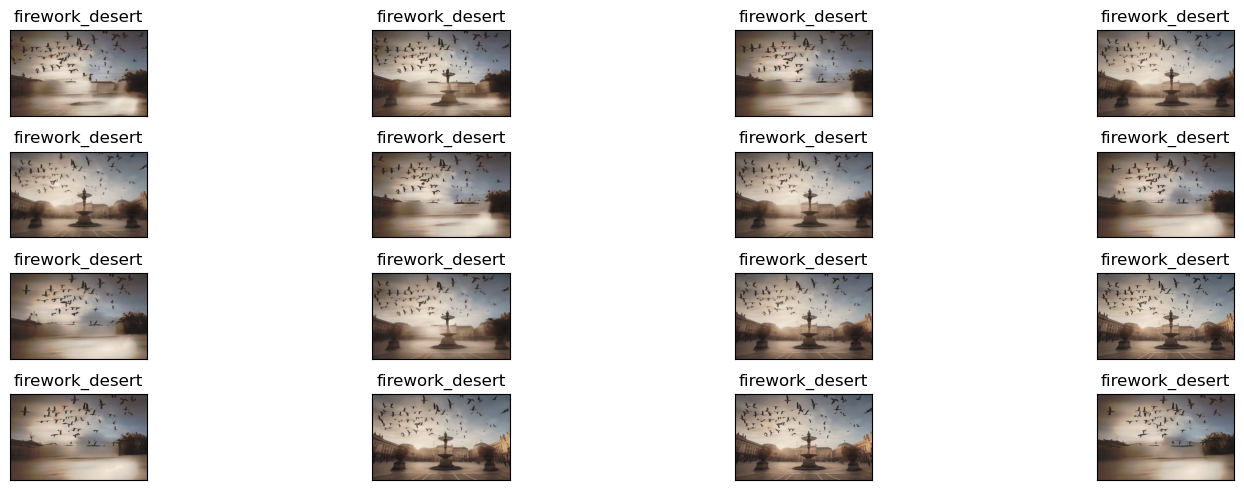

In [34]:
import os
import test6_img
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
test6_img_dir = "test5_img"


original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(test6_img_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    
    image = Image.open(os.path.join(test6_img_dir, filename)).convert("RGB")
  
    plt.subplot(4, 4, len(images) + 1)
    plt.imshow(image)
    plt.title("firework_desert")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append("firework_desert")

plt.tight_layout()

In [35]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

In [36]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    print(image_features.shape)
    text_features = model.encode_text(text_tokens).float()

torch.Size([16, 512])


In [37]:
####Consistancy and Diversity####
import torch
from scipy.spatial.distance import cosine
from itertools import combinations

def calculate_consistency(image_features):
    # cosine similarity
    similarities = []
    for (emb1, emb2) in combinations(image_features, 2):
        sim = torch.nn.functional.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
        similarities.append(sim.item())
    # average 
    consistency = torch.mean(torch.tensor(similarities))
    return consistency

def calculate_diversity(image_features):
    # average 
    avg_embedding = torch.mean(image_features, dim=0, keepdim=True)
    # each frame compare with average 
    distances = [torch.nn.functional.cosine_similarity(avg_embedding, emb.unsqueeze(0)) for emb in image_features]
    # average
    diversity = torch.mean(torch.tensor(distances))
    return diversity

consistency = calculate_consistency(image_features)
diversity = calculate_diversity(image_features)

print(f"Consistency: {consistency}")
print(f"Diversity: {diversity}")


Consistency: 0.850945234298706
Diversity: 0.9274251461029053


In [23]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
print(similarity)

[[0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]
 [0.33394188 0.33205244 0.32122615 0.3330684  0.34756845 0.32409826
  0.34440687 0.32844394]]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

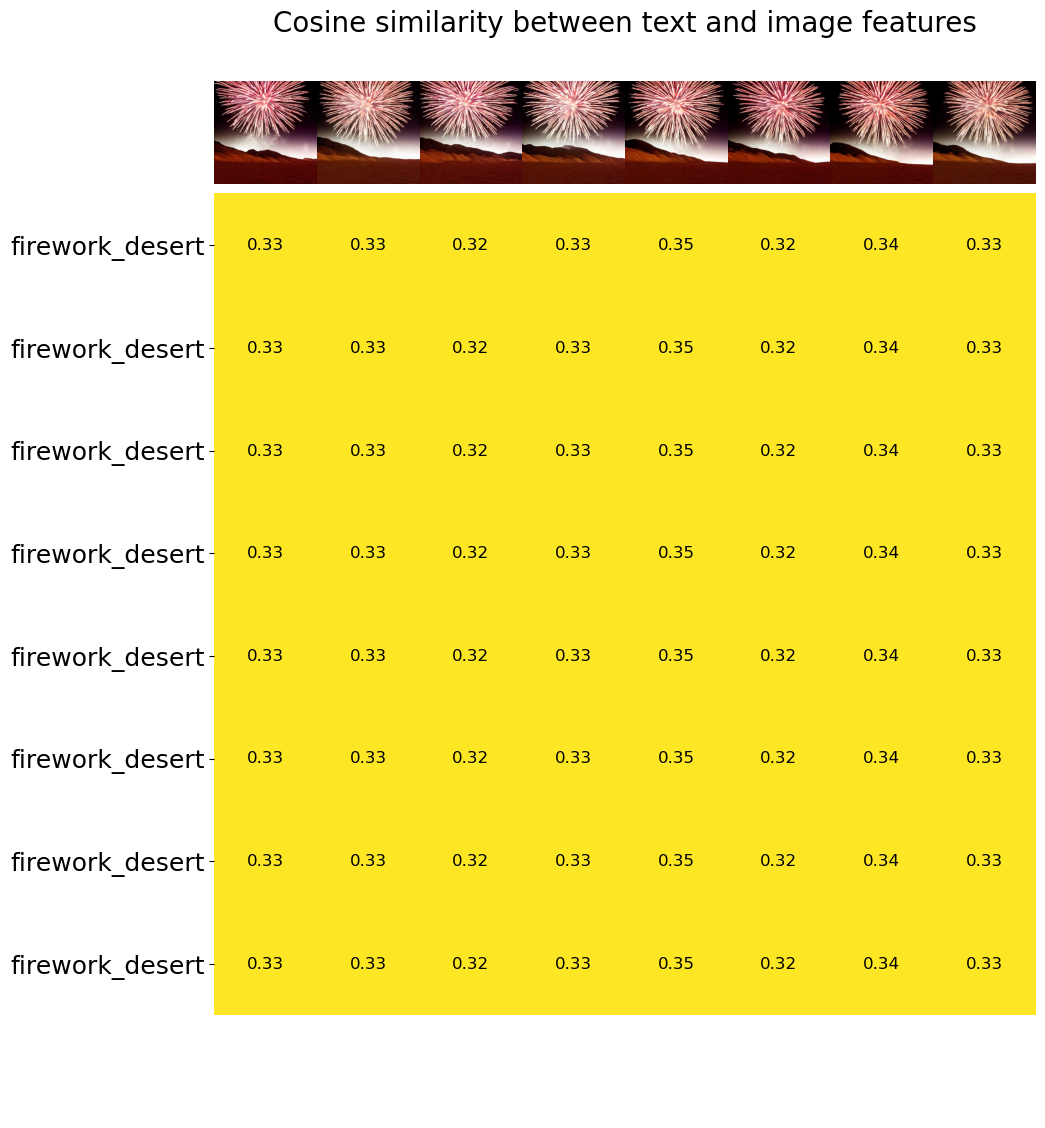

In [22]:
count = 8

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)